# COSC 74: Machine Learning

## Homework  4

### Needed Imports

In [627]:
import pandas as pd
import numpy as np
from numpy import typing as npt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

### 1. Load the Data and Partition it

80% of the data is used for training and 20% for testing.

In [628]:
df = pd.read_csv("hw4_naive.csv")
print(df.head())

dataset = np.array(df)

trainset, testset = train_test_split(dataset, test_size=0.2, random_state=0)


   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  Label
0    7430.14    9529.78   -2453.33         19        123        621      0
1   11256.40   50455.10   -4220.00         18        216       2677      0
2   13093.00   51897.10   -2880.00         30        234       2464      0
3   14303.00  102632.00   -5702.20        144        281       4061      1
4   14688.00   83343.40   -2430.00         52        223       2822      1


### 2. Multinomial Naivë Bayes classifier with Smooting 

In [629]:
class NaiveBayes():
    """
    Naive Bayes Predictor.

    """

    def __init__(self, trainset=None, smoothing_coeff=1):
        """
            Initializes the Naive Bayes predictor.

            Inputs:
            -------
                `trainset`: 2D numpy array of training data.
                    >>> NOTE: The last column of the data is the class label.
                `smoothing_coeff`: float, smoothing coefficient
                        for multinomial classifier.
                        Default value = 1.

        """

        self.possible_classes = list(np.unique(trainset[:, -1]))
        self.trainset: npt.NDArray = trainset
        self.smoothing_coeff: float = smoothing_coeff
        self.feature_count: int = self.trainset.shape[1] - 1

        # these variables are used by the gaussian classifier
        self.gaussian_means = None
        self.gaussian_variance = None

    def multinomial(self, feature_vector):
        """
            Calculates the probability of each class given the data.

            Inputs:
            -------

            `feature_vector`: 1D numpy array for aa single row of data.

            Returns:
            --------
            A classification for the feature vector,
            based on the priorly saved X_train and y_train.

        """

        class_count = len(self.possible_classes)
        classes = np.array([0 for _ in range(class_count)])
        class_totals = np.array([0 for _ in self.possible_classes])
        for record in self.trainset:
            label = record[-1]
            class_index = self.possible_classes.index(label)
            for feature in range(self.feature_count):
                if record[feature] == feature_vector[feature]:
                    classes[class_index] += 1

                class_totals[class_index] += 1

        probabilities = (classes + self.smoothing_coeff) / (class_totals + class_count)
        return self.possible_classes[np.argmax(probabilities)]

    def multinomial_predictions(self, feature_vectors):
        """
            Calculates the multinomial predictions for each record in a matrix.

            Inputs:
            -------
                `feature_vectors`: 2D numpy array of feature vectors.
            
            Outputs:
            --------
                `predictions`: 1D list of predictions.

        """
        return np.apply_along_axis(self.multinomial, 1, feature_vectors)
    
    def gaussian(self, feature_vector):
        """
            Calculates the probability of each class given the data.

            Inputs:
            -------

            `feature_vector`: 1D numpy array for aa single row of data.

            Returns:
            --------
            A classification for the feature vector,
            based on the priorly saved X_train and y_train.

        """
        if feature_vector.shape[0] == self.feature_count + 1:
            feature_vector = feature_vector[:-1]


        # if means and variance are not initialized, initialize them
        if self.gaussian_means is None:
            self.gaussian_means = []
            self.gaussian_variance = []

            for possible_class in self.possible_classes:
                class_data = self.trainset[self.trainset[:, -1] == possible_class]
                class_mean = np.mean(class_data[:, :-1], axis=0)
                class_variance = np.var(class_data[:, :-1], axis=0)
                self.gaussian_means.append(class_mean)
                self.gaussian_variance.append(class_variance)

        probabilities = []
        for possible_class in range(len(self.possible_classes)):
            class_mean = self.gaussian_means[possible_class]
            class_variance = self.gaussian_variance[possible_class]
            prob = (1 / (np.sqrt(2 * np.pi * class_variance)))
            prob *= np.exp(-( (feature_vector - class_mean) ** 2) / (2 * class_variance))
            probabilities.append(np.product(prob))
            
        return self.possible_classes[np.argmax(probabilities)]

    def gaussian_predictions(self, feature_vectors):
        """
            Calculates the multinomial predictions for each record in a matrix.

            Inputs:
            -------
                `feature_vectors`: 2D numpy array of feature vectors.
            
            Outputs:
            --------
                `predictions`: 1D list of predictions.

        """
        return np.apply_along_axis(self.gaussian, 1, feature_vectors)


### Test Multinomial Naive Bayes classifier with Smoothing.

In [630]:
nb = NaiveBayes(trainset)
multinomial_predictions = nb.multinomial_predictions(testset)

# print(f"{multinomial_predictions = }")

# check the accuracy of the predictions
count = len(multinomial_predictions)
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for i in range(count):
    prediction = multinomial_predictions[i]
    if prediction == testset[i][-1]:
        if prediction == 1:
            true_positive += 1
        else:
            true_negative += 1
    else:
        if prediction == 1:
            false_positive += 1
        else:
            false_negative += 1

correct = true_positive + true_negative
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1 = 2 * precision * recall / (precision + recall)
print(f"{correct = }, total = {count}")
print(f"{precision = }\n{recall = }\n{f1 = }")
print(f"accuracy = {correct / count}")

correct = 865, total = 1120
precision = 0.8523076923076923
recall = 0.5723140495867769
f1 = 0.684796044499382
accuracy = 0.7723214285714286


### Test Gaussian Naive Bayes classifier.

In [631]:
# nb = NaiveBayes(trainset)  # if initialized above, no need to initialize here.
gaussian_predictions = nb.gaussian_predictions(testset)

# print(gaussian_predictions)

# check the accuracy of the predictions
count = len(gaussian_predictions)
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for i in range(count):
    prediction = gaussian_predictions[i]
    if prediction == testset[i][-1]:
        if prediction == 1:
            true_positive += 1
        else:
            true_negative += 1
    else:
        if prediction == 1:
            false_positive += 1
        else:
            false_negative += 1

correct = true_positive + true_negative
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1 = 2 * precision * recall / (precision + recall)
print(f"{correct = }, total = {count}")
print(f"{precision = }\n{recall = }\n{f1 = }")
print(f"accuracy = {correct / count}")

correct = 666, total = 1120
precision = 0.5707547169811321
recall = 0.25
f1 = 0.34770114942528735
accuracy = 0.5946428571428571


---


##  Bonus Questions: Clustering

- Given a [training dataset](./hw4_cluster.csv) containing 40 rows, each with 2 columns.
- Column 1 & 2 are the features.
- There are no labels for this dataset.
- Implement different clustering algorithms and run them on this
dataset. 
- **Assume the distance function is _Euclidean Distance_.**

### 1 (35 points) Implement a generalized K-means/median algorithm.

  - You should have a single function that takes in as input the data points, K,
    and some other hyperparameters specified below.
  - The function should return K sets of data points, each set corresponding to one cluster.

Hyperparameters:

- The method for calculating the centroid: Means or Median
- The initialization method: Random Split Initialization or Random Seed Selection Method
- Max_iter: max number of iterations to run the algorithm.
- K: number of clusters

         x1        x2
0 -0.201517 -0.683358
1  0.374519 -0.828082
2 -0.161895 -1.247107
3  0.037711 -0.047303
4 -0.260479  1.770204


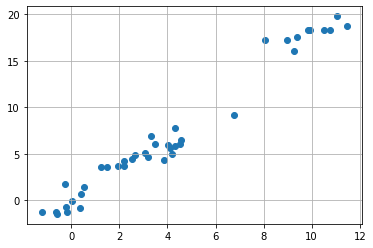

In [632]:
dataframe = pd.read_csv('hw4_cluster.csv')
print(dataframe.head())
data = np.array(dataframe)

# visualize the data
plt.scatter(data[:, 0], data[:, 1])
plt.grid()
plt.show()

#### Convenience Representation of a Point


In [633]:
class Point():
    def __init__(self, coordinates):
        self.coordinates = np.array(coordinates)
        self.cluster = None
    
    def __hash__(self):
        return hash(tuple(self.coordinates))

    def __str__(self):
        return str(self.coordinates)

    def __eq__(self, other):
        return np.array_equal(self.coordinates, other.coordinates)



#### 1.1 Distance Function

In [634]:
def distance(p1: Point, p2: Point) -> float:
    separation = p1.coordinates - p2.coordinates
    return np.sqrt(np.dot(separation, separation))

print(f"{distance(Point([0, 3]), Point([4, 0])) = }")

distance(Point([0, 3]), Point([4, 0])) = 5.0


#### 1.2 Centroid Functions

In [635]:
def mean_centroid(points: list[Point]):
    all_coordinates = np.array([p.coordinates for p in points])
    return Point(np.mean(all_coordinates, axis=0))

def median_centroid(points):
    all_coordinates = np.array([p.coordinates for p in points])
    return Point(np.median(all_coordinates, axis=0))

datapoints = [Point(p) for p in data]
mean = mean_centroid(datapoints)
median = median_centroid(datapoints)
print(f"mean = {mean}")
print(f"median = {median}")



mean = [4.13574432 7.09951132]
median = [3.39533665 4.99323915]


#### 1.3 Initialization Methods


In [636]:

def random_split(points: list, k):
    clusters = [set() for _ in range(k)]
    cluster_size = len(points) // k
    for _ in range(cluster_size):
        for cluster in range(k):
            index = np.random.randint(0, len(points))
            point = points.pop(index)
            point.cluster = cluster
            clusters[cluster].add(point)
    return clusters
        
def random_seed(points: list, k):
    clusters = [set() for _ in range(k)]
    for cluster in range(k):
        index = np.random.randint(0, len(points))
        point = points.pop(index)
        point.cluster = cluster
        clusters[cluster].add(point)
    return clusters

#### 1.4 K-means/median algorithm

In [651]:

def cluster(points, centroid_func, init_func, max_iter, k):
    
    pts = [Point(p) for p in points]
    clusters = init_func(pts.copy(), k)
    

    for iter in range(max_iter):

        change = False
        centroids = [centroid_func(cluster) for cluster in clusters]

        for pt in pts:
            min_dist = float('inf')
            min_cluster = 0
            for cluster in range(k):
                dist = distance(pt, centroids[cluster])
                if dist < min_dist:
                    min_dist = dist
                    min_cluster = cluster

            old_cluster = pt.cluster
            if old_cluster is None or old_cluster != min_cluster:
                change = True
                if old_cluster is not None:
                    clusters[old_cluster].remove(pt)
                clusters[min_cluster].add(pt)
                pt.cluster = min_cluster
        
        if not change:
            print(f"Converged at iteration {iter}")
            break
    return clusters

#### Test the Algorithm


In [652]:
k = 5
clusters = cluster(data, mean_centroid, random_split, 1000, k)
# clusters = [[p.coordinates for p in cluster] for cluster in clusters]
# print(clusters)
print(f"cluster sizes = {[len(c) for c in clusters]}")

Converged at iteration 4
cluster sizes = [0, 10, 10, 18, 2]


#### 2. SSE Score

Implement a function to take in a list of clusters and calculate the SSE score.

In [647]:
def SSE(centroid_func, clusters):
    sse = 0.0
    for cluster in clusters:
        centroid = centroid_func(cluster)
        for point in cluster:
            sse += distance(point, centroid)
    return sse

sse_score = SSE(mean_centroid, clusters)
print(f"SSE = {sse_score}")

SSE = 38.43293302177801


#### 3. Finding the best K

Run the code you implemented in question 1 for $k \in \{2, 3, 4, 5\}$.

Set the other hyperparameters as follows:

- The method for calculating the centroid: Mean
- The initialization method: Random Split Initialization
- Max_iterations: 100

Calculate the SSE for each K using the function in question 2 and use these scores to pick the best K. What is the best K?

> Per the performance of the predictions below, it seems the best $k$ is $5$
>
> This makes sense since the more groups we can create, the more compact we can make those clusters.
>
> ...but the quality of the information we get from those predictions goes down.

Converged at iteration 3
Converged at iteration 5
Converged at iteration 4
Converged at iteration 4
k = 2, SSE = 105.18805496092499
k = 3, SSE = 55.41320608126317
k = 4, SSE = 49.62723344463008
k = 5, SSE = 38.43293302177801


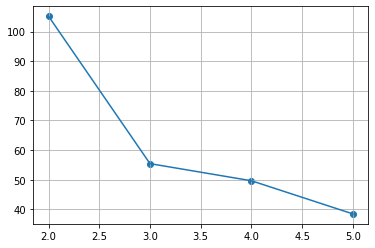

In [655]:
centroid_func = mean_centroid
init_func = random_split
max_iterations = 1000
K = [2, 3, 4, 5]

sse_scores = []
all_clusters = []
for k in K:
    clusters = cluster(data, centroid_func, init_func, max_iterations, k)
    all_clusters.append(clusters)
    sse_scores.append(SSE(centroid_func, clusters))

for k, sse in zip(K, sse_scores):
    print(f"k = {k}, SSE = {sse}")
plt.scatter(K, sse_scores)
plt.plot(K, sse_scores)
plt.grid()
plt.show()



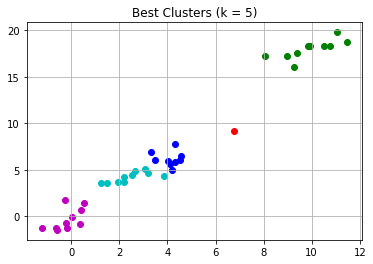

In [658]:

best_clusters = all_clusters[np.argmin(sse_scores)]

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for c in range(len(best_clusters)):
    points = best_clusters[c]
    raw_points = [p.coordinates for p in points]
    x = [p[0] for p in raw_points]
    y = [p[1] for p in raw_points]
    plt.scatter(x, y, color=colors[c])
plt.grid()
plt.title(f"Best Clusters (k = {K[np.argmin(sse_scores)]})")
plt.show()

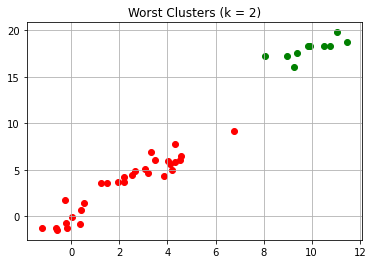

In [659]:
worst_clusters = all_clusters[np.argmax(sse_scores)]

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for c in range(len(worst_clusters)):
    points = worst_clusters[c]
    raw_points = [p.coordinates for p in points]
    x = [p[0] for p in raw_points]
    y = [p[1] for p in raw_points]
    plt.scatter(x, y, color=colors[c])
plt.grid()
plt.title(f"Worst Clusters (k = {K[np.argmax(sse_scores)]})")
plt.show()